# An attempt at an elegant solution to the 2D -> 3D object relation problem.
I will use graph theory to solve this problem. 
The idea is to create a graph where each node represents a 2D object and each edge represents a potential relation between two objects across z or an absolute relation between two objects in the same z.
These edges will be weighted based on their z distance.
The problem then becomes a shortest path problem where we need to find the shortest path between the start and end nodes.
An issue that will arise is figuring out how many nodes might exist in a given path. This will vary and will be a challenge to solve.
Some nodes will not start until a certain z level and some nodes will end at a certain z level.

### To do this we must make the following assumptions:
1. Nodes in the same z level are connected to each other, but will not be used in the shortest path calculation - these are separate objects.
2. The variablility in the distance between the X-Y coordinates across z-slices for the same 3D object is minimal.
    - This will be a learned or assumed value - probably initialized as apriori knowledge.
3. The distance between the X-Y coordinates across z-slices for different 3D objects is significant.
4. Given the assumption of 1 and 2, we do not need to calculate the shortes path between all nodes, only the nodes that are within a certain distance of each other in the X-Y plane across z-slices.
5. The total number of objects in a 2D slice cannot be greater than the total number of objects in the 3D object.
6. The largest number of objects across all 2D slices will not necessarily be the same as the number of objects in the 3D object.
7. The node path has to be continuous and cannot skip nodes.

## Imports

In [1]:
import argparse
import pathlib
import sys

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import skimage
import tifffile
import tqdm

# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

# Get the current working directory
cwd = pathlib.Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd

else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break

# Check if a Git root directory was found
if root_dir is None:
    raise FileNotFoundError("No Git root directory found.")


sys.path.append(f"{root_dir}/utils")
from segmentation_decoupling import euclidian_2D_distance

In [2]:
if not in_notebook:
    print("Running as script")
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")

    parser.add_argument(
        "--patient",
        type=str,
        help="The patient ID",
    )

    parser.add_argument(
        "--well_fov",
        type=str,
        help="Path to the input directory containing the tiff images",
    )

    parser.add_argument(
        "--compartment",
        type=str,
        default="none",
        help="The compartment to segment",
    )

    args = parser.parse_args()
    well_fov = args.well_fov
    compartment = args.compartment
    patient = args.patient
else:
    print("Running in a notebook")
    well_fov = "C10-1"
    compartment = "nuclei"
    patient = "NF0021"

input_dir = pathlib.Path(
    f"{root_dir}/data/{patient}/segmentation_masks/{well_fov}"
).resolve()
mask_dir = pathlib.Path(
    f"{root_dir}/data/{patient}/segmentation_masks/{well_fov}"
).resolve()
if compartment == "nuclei":
    input_image_dir = pathlib.Path(mask_dir / "nuclei_masks_decoupled.tiff").resolve(
        strict=True
    )
    x_y_vector_radius_max_constraint = 25  # pixels
    overlap_percent = 0.75
    output_image_dir = pathlib.Path(
        mask_dir / "nuclei_masks_reconstructed.tiff"
    ).resolve()
elif compartment == "cell":
    input_image_dir = pathlib.Path(mask_dir / "cell_masks_decoupled.tiff").resolve(
        strict=True
    )
    x_y_vector_radius_max_constraint = 25  # pixels
    overlap_percent = 0.9
    output_image_dir = pathlib.Path(
        mask_dir / "cell_masks_reconstructed.tiff"
    ).resolve()
elif compartment == "organoid":
    input_image_dir = pathlib.Path(mask_dir / "organoid_masks_decoupled.tiff").resolve(
        strict=True
    )
    x_y_vector_radius_max_constraint = 1000  # pixels
    overlap_percent = 0.9
    output_image_dir = pathlib.Path(
        mask_dir / "organoid_masks_reconstructed.tiff"
    ).resolve()
else:
    raise ValueError(
        "Invalid compartment, please choose either 'nuclei', 'cell', or 'organoid'"
    )

Running in a notebook


## Extract masks and masks centers (XY coordinates) from the input image

In [3]:
image = tifffile.imread(input_image_dir)

In [4]:
cordinates = {
    "original_label": [],
    "slice": [],
    "centroid-0": [],
    "centroid-1": [],
    "bbox-0": [],
    "bbox-1": [],
    "bbox-2": [],
    "bbox-3": [],
}

for slice in range(image.shape[0]):
    props = skimage.measure.regionprops_table(
        image[slice, :, :], properties=["label", "centroid", "bbox"]
    )

    label, centroid1, centroid2, bbox0, bbox1, bbox2, bbox3 = (
        props["label"],
        props["centroid-0"],
        props["centroid-1"],
        props["bbox-0"],
        props["bbox-1"],
        props["bbox-2"],
        props["bbox-3"],
    )
    if len(label) > 0:
        for i in range(len(label)):
            cordinates["original_label"].append(label[i])
            cordinates["slice"].append(slice)
            cordinates["centroid-0"].append(centroid1[i])
            cordinates["centroid-1"].append(centroid2[i])
            cordinates["bbox-0"].append(bbox0[i])
            cordinates["bbox-1"].append(bbox1[i])
            cordinates["bbox-2"].append(bbox2[i])
            cordinates["bbox-3"].append(bbox3[i])


coordinates_df = pd.DataFrame(cordinates)
coordinates_df["unique_id"] = coordinates_df.index
coordinates_df.head()

,original_label,slice,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,unique_id
0,1,4,660.207444,789.322758,624,755,700,822,0
1,2,4,693.709522,848.858627,656,811,735,888,1
2,1,8,771.739130,804.869565,746,794,789,836,2
3,1,12,755.558531,770.827669,723,742,787,802,3


## Plot the coordinates of the masks in the XY plane

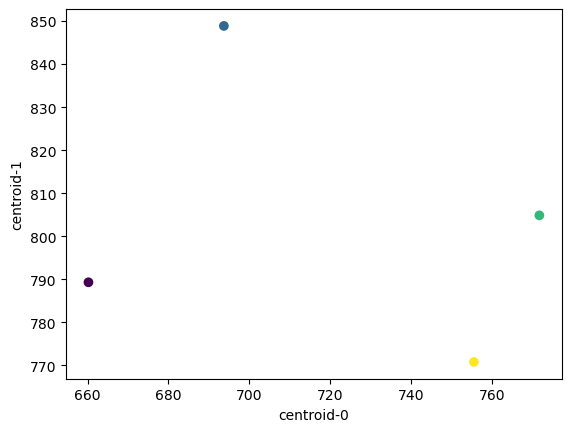

In [5]:
if in_notebook:
    # plot the data
    fig, ax = plt.subplots()
    plt.scatter(
        coordinates_df["centroid-0"],
        coordinates_df["centroid-1"],
        c=coordinates_df["unique_id"],
    )
    plt.xlabel("centroid-0")
    plt.ylabel("centroid-1")
    plt.show()

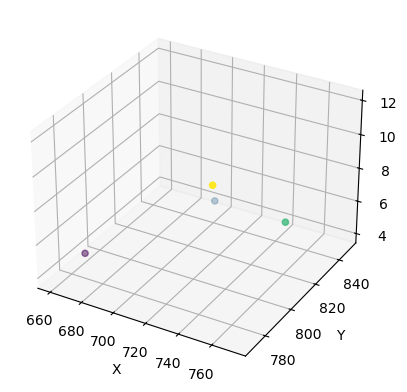

In [6]:
if in_notebook:
    # make a 3D graph of each x-y center of mass
    # Create a new figure
    fig = plt.figure()

    # Add a 3D subplot
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(
        coordinates_df["centroid-0"],
        coordinates_df["centroid-1"],
        coordinates_df["slice"],
        c=coordinates_df["unique_id"],
    )
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

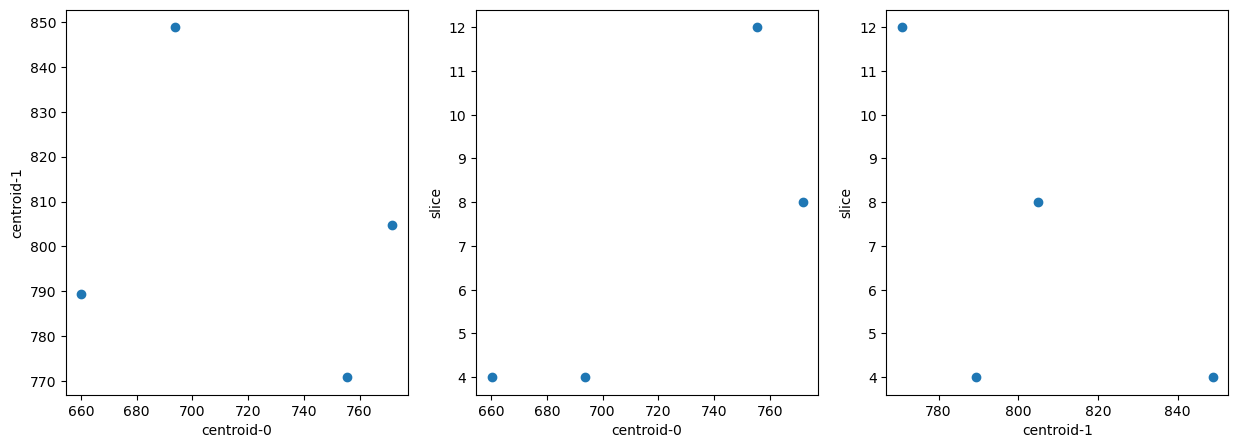

In [7]:
if in_notebook:
    # plot the centroid for x-y, x-z, and y-z
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].scatter(coordinates_df["centroid-0"], coordinates_df["centroid-1"])
    ax[0].set_xlabel("centroid-0")
    ax[0].set_ylabel("centroid-1")
    ax[1].scatter(coordinates_df["centroid-0"], coordinates_df["slice"])
    ax[1].set_xlabel("centroid-0")
    ax[1].set_ylabel("slice")
    ax[2].scatter(coordinates_df["centroid-1"], coordinates_df["slice"])
    ax[2].set_xlabel("centroid-1")
    ax[2].set_ylabel("slice")
    plt.show()

In [8]:
from typing import Tuple


def calculate_bbox_area(bbox: Tuple[int, int, int, int]) -> int:
    """
    Calculate the area of a bounding box.

    Parameters
    ----------
    bbox : Tuple[int, int, int, int]
        The bounding box coordinates in the format (x_min, y_min, x_max, y_max).

    Returns
    -------
    int
        The area of the bounding box.
    """
    return max(0, bbox[2] - bbox[0]) * max(0, bbox[3] - bbox[1])


def calculate_overlap(
    bbox1: tuple[int, int, int, int], bbox2: tuple[int, int, int, int]
) -> float:
    """
    Calculate the percentage overlap between two bounding boxes.

    Parameters
    ----------
    bbox1 : Tuple[int, int, int, int]
        The first bounding box (x_min, y_min, x_max, y_max).
    bbox2 : Tuple[int, int, int, int]
        The second bounding box (x_min, y_min, x_max, y_max).

    Returns
    -------
    float
        The percentage overlap of the smaller bounding box with the larger one.
    """
    # Calculate intersection coordinates
    x_min = max(bbox1[0], bbox2[0])
    y_min = max(bbox1[1], bbox2[1])
    x_max = min(bbox1[2], bbox2[2])
    y_max = min(bbox1[3], bbox2[3])

    # Calculate intersection area
    overlap_width = max(0, x_max - x_min)
    overlap_height = max(0, y_max - y_min)
    overlap_area = overlap_width * overlap_height

    # Calculate areas of both bounding boxes
    area1 = calculate_bbox_area(bbox1)
    area2 = calculate_bbox_area(bbox2)

    # Return the percentage overlap relative to the smaller bounding box
    smaller_area = min(area1, area2)
    return overlap_area / smaller_area if smaller_area > 0 else 0.0


def calculate_mask_iou(mask1: np.ndarray, mask2: np.ndarray) -> bool:
    """
    Calculate the Intersection over Union (IoU) between two binary masks.

    Parameters
    ----------
    mask1 : np.ndarray
        The first binary mask.
    mask2 : np.ndarray
        The second binary mask.

    Returns
    -------
    bool
        True if the IoU is greater than 0.5, False otherwise.
    """
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)

    if np.sum(union) == 0:
        return False

    iou = np.sum(intersection) / np.sum(union)

    return iou

In [9]:
# generate distance pairs for each slice
distance_pairs = []
distance_pairs = {
    "slice1": [],
    "slice2": [],
    "index1": [],
    "index2": [],
    "distance": [],
    "coordinates1": [],
    "coordinates2": [],
    "pass": [],
    "original_label1": [],
    "original_label2": [],
}

distance_pairs_list = [
    {
        "slice1": coordinates_df.loc[i, "slice"],
        "slice2": coordinates_df.loc[j, "slice"],
        "index1": i,
        "index2": j,
        "distance": euclidian_2D_distance(
            coordinates_df.loc[i, ["centroid-0", "centroid-1"]].values,
            coordinates_df.loc[j, ["centroid-0", "centroid-1"]].values,
        ),
        "coordinates1": tuple(
            coordinates_df.loc[i, ["centroid-0", "centroid-1"]].values
        ),
        "coordinates2": tuple(
            coordinates_df.loc[j, ["centroid-0", "centroid-1"]].values
        ),
        "pass": True,
        "original_label1": coordinates_df.loc[i, "original_label"],
        "original_label2": coordinates_df.loc[j, "original_label"],
    }
    for i in range(coordinates_df.shape[0])
    for j in range(coordinates_df.shape[0])
    if i != j
    and euclidian_2D_distance(
        coordinates_df.loc[i, ["centroid-0", "centroid-1"]].values,
        coordinates_df.loc[j, ["centroid-0", "centroid-1"]].values,
    )
    < x_y_vector_radius_max_constraint
]

# Convert to DataFrame (if needed)
df = pd.DataFrame(distance_pairs_list)
if not df.empty:
    df["indexes"] = df["index1"].astype(str) + "-" + df["index2"].astype(str)
    df = df[df["pass"] == True]
    df["index_comparison"] = df["index1"].astype(str) + "," + df["index2"].astype(str)
    df.head()

In [10]:
# create a graph where each node is a unique centroid and each edge is a distance between centroids
# edges between nodes with the same slice are not allowed
# edge weight is the distance between the nodes (euclidian distance)
G = nx.Graph()
for row in df.iterrows():
    G.add_node(
        row[1]["index1"], slice=row[1]["slice1"], coordinates=row[1]["coordinates1"]
    )
    G.add_node(
        row[1]["index2"], slice=row[1]["slice2"], coordinates=row[1]["coordinates2"]
    )
    G.add_edge(
        row[1]["index1"],
        row[1]["index2"],
        weight=row[1]["distance"],
        original_label1=row[1]["original_label1"],
        original_label2=row[1]["original_label2"],
    )

# plot the graph with each slice being on a different row
pos = nx.spring_layout(G)
edge_labels = nx.get_edge_attributes(G, "weight")

In [11]:
# solve the the shortest path problem
# find the longest paths in the graph with the smallest edge weights
# this will find the longest paths between centroids closest to each other
# the longest path is the path with the most edges
longest_paths = []
for path in nx.all_pairs_shortest_path(G, cutoff=10):
    longest_path = []
    for key in path[1].keys():
        if len(path[1][key]) > len(longest_path):
            longest_path = path[1][key]
    longest_paths.append(longest_path)

In [12]:
def merge_sets(list_of_sets: list) -> list:
    for i, set1 in enumerate(list_of_sets):
        for j, set2 in enumerate(list_of_sets):
            if i != j and len(set1.intersection(set2)) > 0:
                set1.update(set2)
    return list_of_sets

In [13]:
list_of_sets = [set(x) for x in longest_paths]
merged_sets = merge_sets(list_of_sets)

In [14]:
merged_sets_dict = {}
for i in range(len(list_of_sets)):
    merged_sets_dict[i] = list_of_sets[i]

In [15]:
for row in coordinates_df.iterrows():
    for num_set in merged_sets_dict:
        if int(row[1]["unique_id"]) in merged_sets_dict[num_set]:
            coordinates_df.at[row[0], "label"] = num_set
# drop nan
coordinates_df = coordinates_df.dropna()
coordinates_df

,original_label,slice,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,unique_id
0,1,4,660.207444,789.322758,624,755,700,822,0
1,2,4,693.709522,848.858627,656,811,735,888,1
2,1,8,771.739130,804.869565,746,794,789,836,2
3,1,12,755.558531,770.827669,723,742,787,802,3


In [16]:
new_mask_image = np.zeros_like(image)
# mask label reassignment
for slice in range(image.shape[0]):
    mask = image[slice, :, :]
    tmp_df = coordinates_df[coordinates_df["slice"] == slice]
    if tmp_df.empty:
        continue
    # check if label is present or if reassignment is needed
    if "label" not in tmp_df.columns:
        continue
    for i in range(tmp_df.shape[0]):
        mask[mask == tmp_df.iloc[i]["original_label"]] = tmp_df.iloc[i]["label"]

    new_mask_image[slice, :, :] = mask
# save the new image
tifffile.imwrite(output_image_dir, new_mask_image)

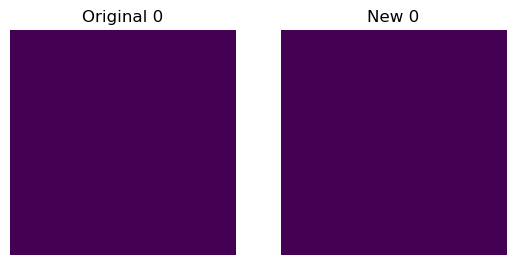

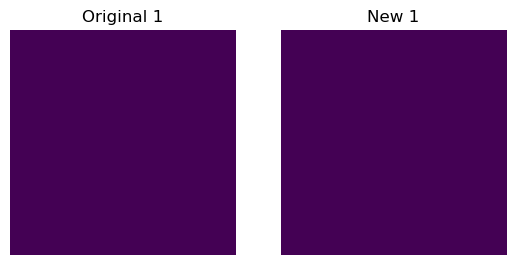

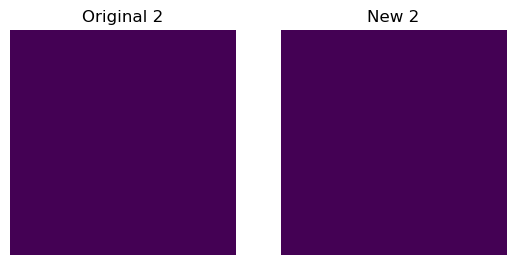

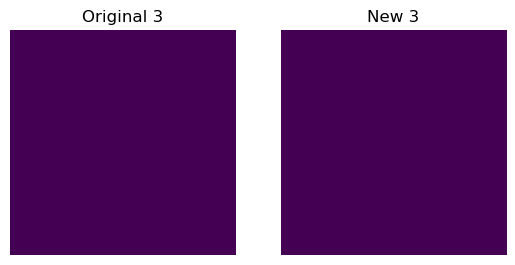

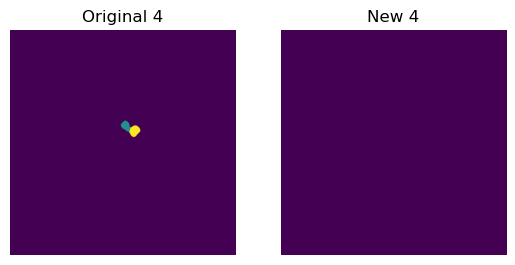

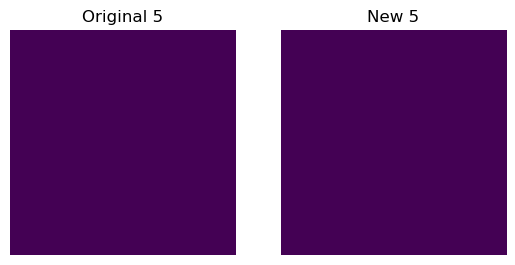

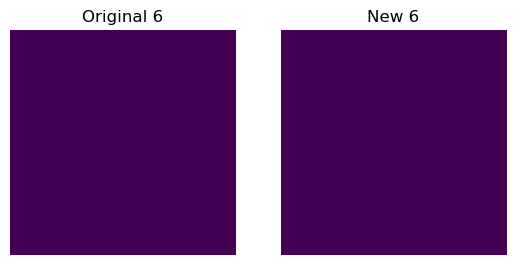

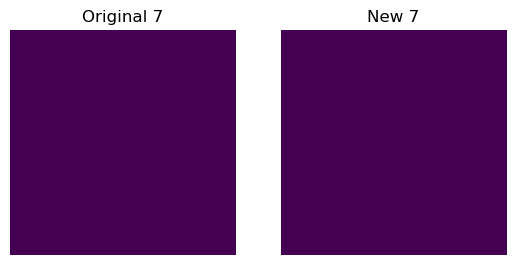

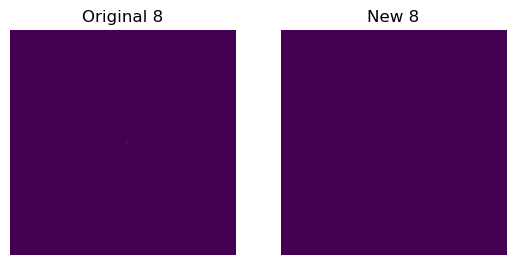

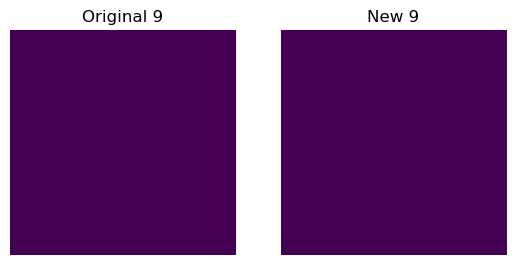

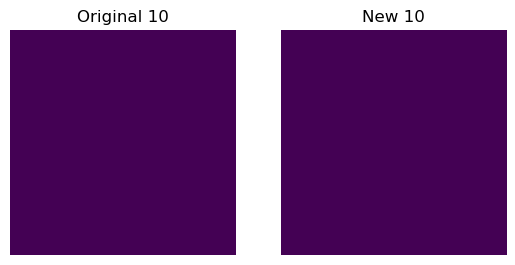

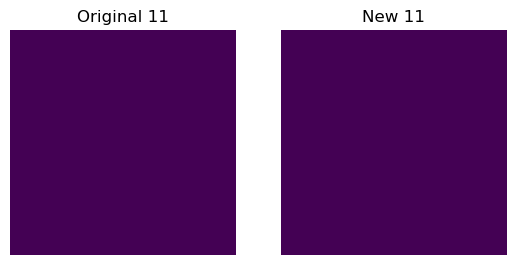

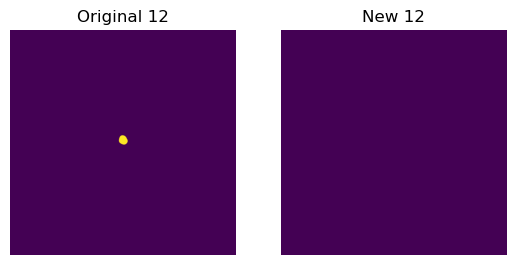

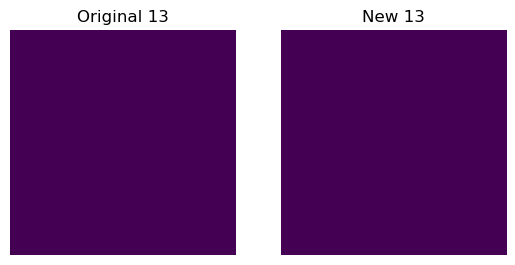

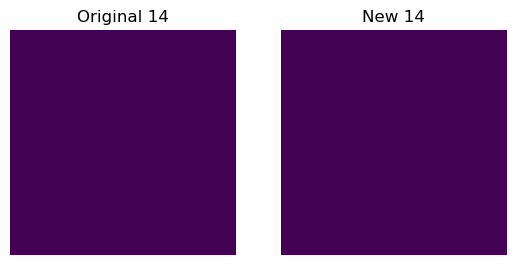

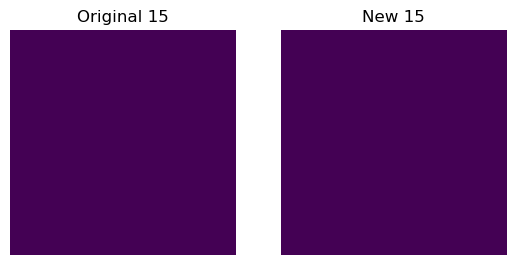

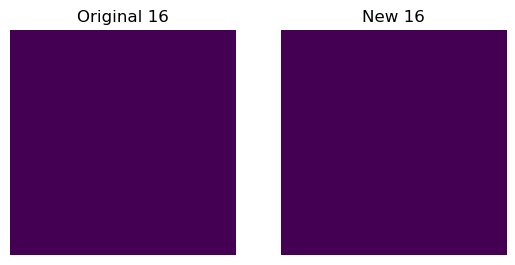

In [17]:
if in_notebook:
    for slice in range(new_mask_image.shape[0]):
        plt.subplot(1, 2, 1)
        plt.imshow(image[slice, :, :])
        plt.title(f"Original {slice}")
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(new_mask_image[slice, :, :])
        plt.title(f"New {slice}")
        plt.axis("off")
        plt.show()